In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import missingno as mn
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Carga el fichero directamente desde el directorio de GitHub

In [2]:
url = "https://raw.githubusercontent.com/Kvaathe/AAMD/main/Trabajo3/day.csv"
sns.set()

In [3]:
dataset = pd.read_csv(url)

Muestra de datos del dataset:

In [4]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Número de filas y columnas del dataset:

In [5]:
dataset.shape

(731, 16)

Información del dataset:

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


Como se puede observar, no hay ninguna variable con valores nulos.

Ahora veremos el resumen del dataset:

In [7]:
dataset.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


Extraemos el año y mes de la fecha para poder trabajar mejor:

In [8]:
dataset['year'] = pd.DatetimeIndex(dataset['dteday']).year

In [9]:
dataset.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,year
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011


Las columnas holiday y workingday son redundantes, por lo que quitamos holiday junto con las otras columnas no necesarias:

In [10]:
dataset.drop(['yr', 'holiday', 'dteday','instant','casual','registered'],axis=1,inplace=True)

In [11]:
dataset.head()

,season,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year
0,1,1,6,0,2,0.344167,0.363625,0.805833,0.160446,985,2011
1,1,1,0,0,2,0.363478,0.353739,0.696087,0.248539,801,2011
2,1,1,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,2011
3,1,1,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,2011
4,1,1,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,2011


Ahora vamos a hacer los datos más leíbles:

1. Season

In [12]:
codes = {1:'Primavera',2:'Verano',3:'Otoño',4:'Invierno'}
dataset['season'] = dataset['season'].map(codes)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


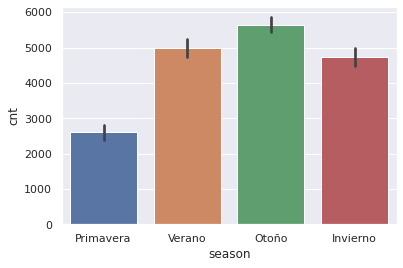

In [13]:
sns.barplot('season','cnt',data=dataset)

Se puede apreciar que en primavera el número de alquieres baja drásticamente. Puede ser debido a que es una temporada en la que el tiempo es más inestable.

2. Weathersit

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


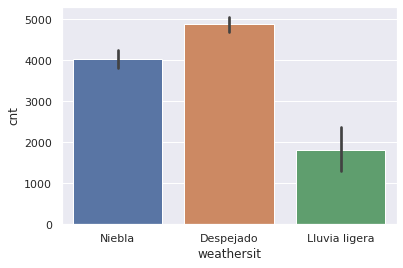

In [14]:
codes = {1:'Despejado',2:'Niebla',3:'Lluvia ligera',4:'Lluvia fuerte'}
dataset['weathersit'] = dataset['weathersit'].map(codes)
sns.barplot('weathersit','cnt',data=dataset)

Podemos ver como no hay ningún alquiler los días en los que llueve fuerte y que hay bastantes menos cuando llueve.

3. Workingday

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


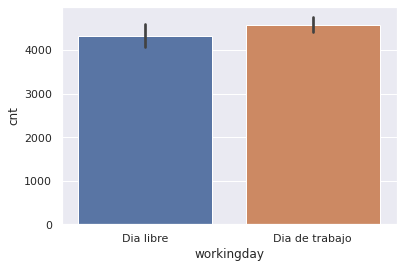

In [15]:
codes = {1:'Dia de trabajo',0:'Dia libre'}
dataset['workingday'] = dataset['workingday'].map(codes)
sns.barplot('workingday','cnt',data=dataset)

Los alquileres están bastante equilibrados sedún se trabaje o no, pero se ve que es ligéramente más elevado en los días de trabajo.

4. Año

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


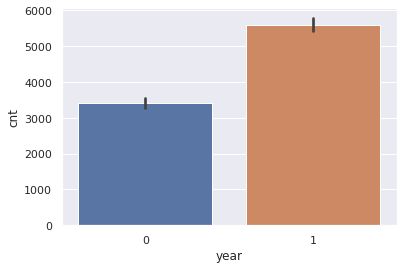

In [16]:
codes = {2012:1,2011:0}
dataset['year'] = dataset['year'].map(codes)
sns.barplot('year','cnt',data=dataset)

Se puede ver que en número de alquileres aumentó en el segundo año. Esto puede ser debido a que la gente estuvo más concienciada de la existencia de las bicicletas y/o fueron convencidas de que funcionan bien y son una buena alternativa al transporte público o cualquier otro vehículo.

5. Mes

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


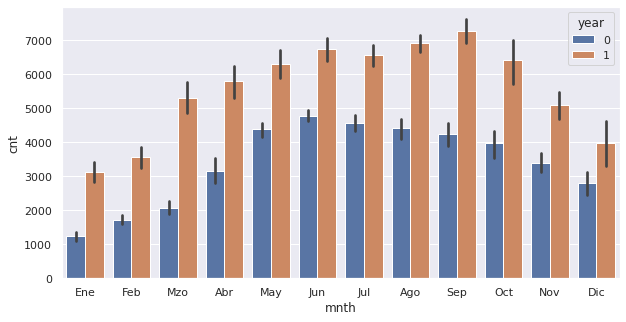

In [17]:
codes = {1:'Ene',2:'Feb',3:'Mzo',4:'Abr',5:'May',6:'Jun',7:'Jul',8:'Ago',9:'Sep',10:'Oct',11:'Nov',12:'Dic'}
dataset['mnth'] = dataset['mnth'].map(codes)
plt.figure(figsize=(10,5))
sns.barplot('mnth','cnt',hue='year',data=dataset)

En esta gráfica, podemos ver que los datos obtenidos por las estaciones concuerdan con los meses.

6. Weekday

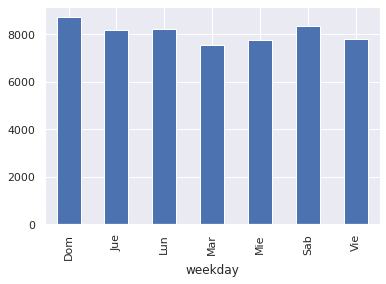

In [18]:
codes = {0:'Lun',1:'Mar',2:'Mie',3:'Jue',4:'Vie',5:'Sab',6:'Dom'}
dataset['weekday'] = dataset['weekday'].map(codes)
dataset.groupby('weekday')['cnt'].max().plot(kind='bar')

En general, los alquieres están balanceados pero son ligéramente mayores durante los fines de semana.

7. Temp

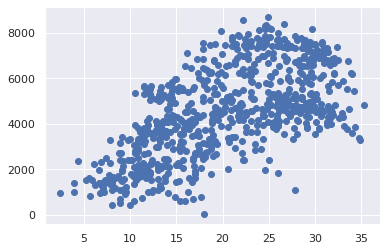

In [19]:
dataset['temp'] = round(dataset['temp'].apply(lambda x: x*41),2)

plt.scatter('temp','cnt',data=dataset)

Aquí podemos ver como afecta la temperatura al alquiler. A bajas temperaturas no se alquilan casi bicicletas y van aumentando a medida que sube la temperatura hasta que hace demasiado calor para ir en bicicleta y los alquileres empiezan a descender.

8. Atemp

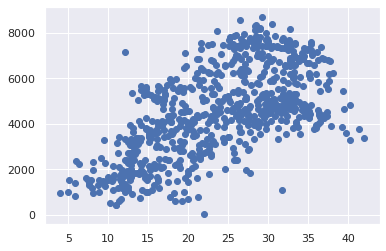

In [20]:
dataset['atemp'] = round(dataset['atemp'].apply(lambda x: x*50),2)

plt.scatter('atemp','cnt',data=dataset)

Lo mismo pasa con la sensación térmica.

9. Humidity

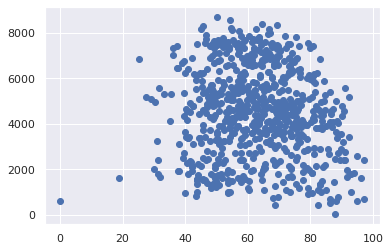

In [21]:
dataset['hum'] = round(dataset['hum'].apply(lambda x: x*100),2)

plt.scatter('hum','cnt',data=dataset)

Se puede observar como los alquileres se centran cuando la humedad está entre el 40% y el 80%.

10. Windspeed

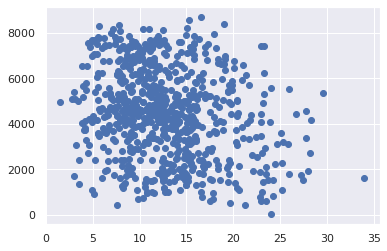

In [22]:
dataset['windspeed'] = round(dataset['windspeed'].apply(lambda x: x*67),2)

plt.scatter('windspeed','cnt',data=dataset)

Entiendo que la velocidad del viento está en millas por hora. Por lo que se puede apreciar que los alquileres empiezan a descender cuando el viento alcanza velocidades de 20 millas por hora.

11. Cnt

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


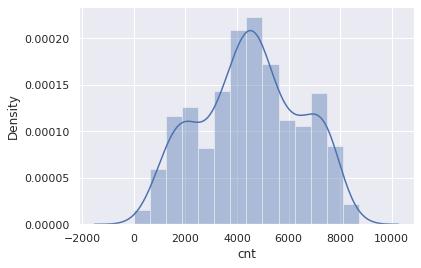

In [23]:
sns.distplot(dataset['cnt'])

Se puede apreciar una distribución multimodal en la gráfica anterior, que representa la variable respuesta cnt.

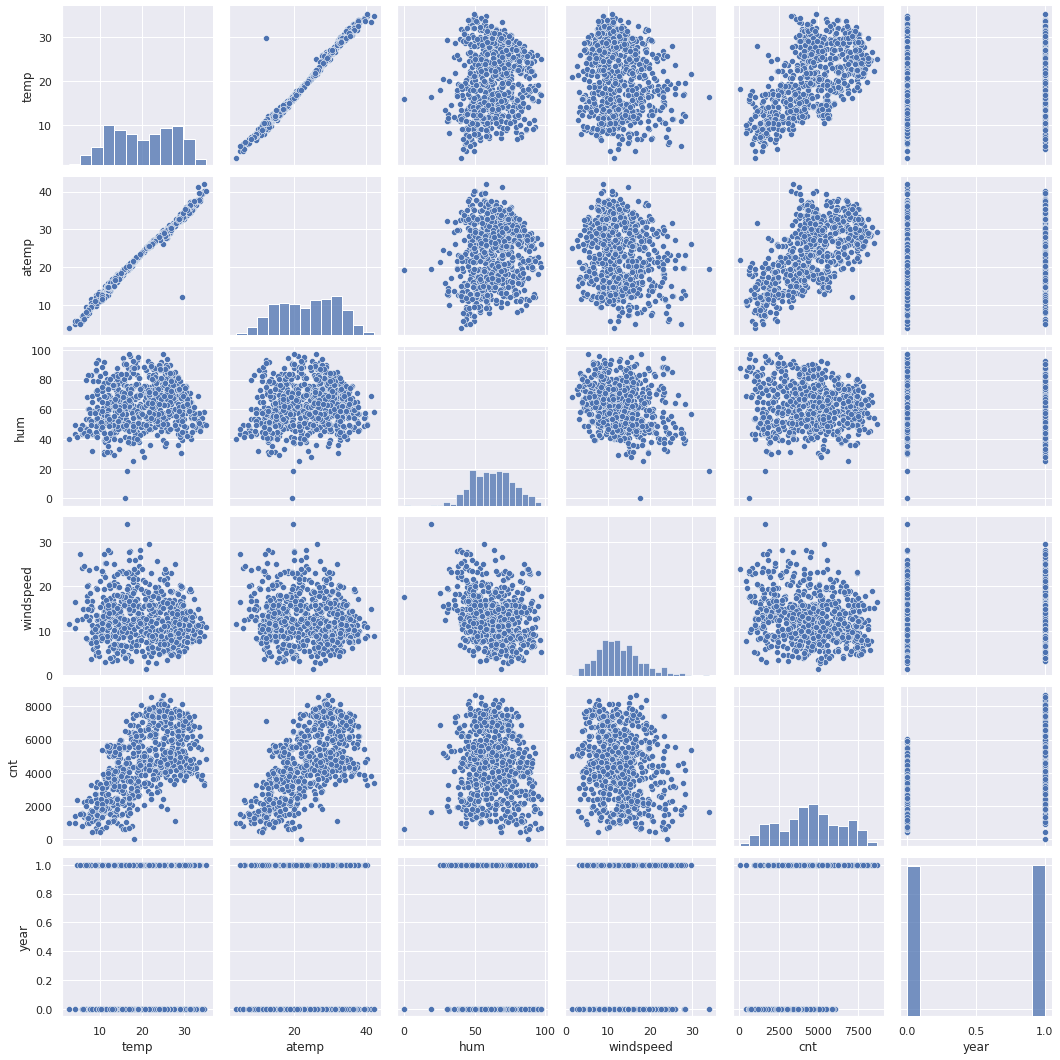

In [24]:
sns.pairplot(dataset)

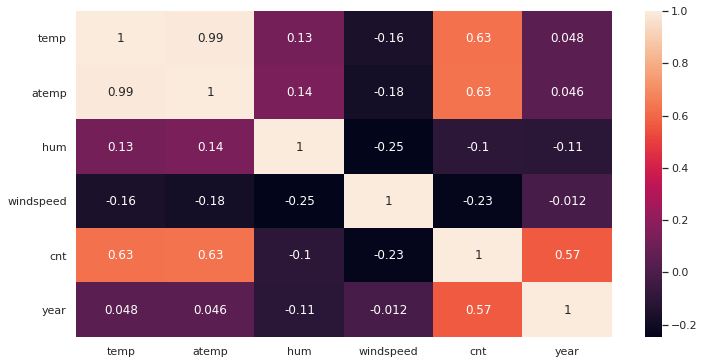

In [25]:
plt.figure(figsize = (12,6))
sns.heatmap(dataset.corr(),annot=True)

Se puede observar que temp y atemp son correlativas, por lo que podemos deshacernos de una de ellas.

In [26]:
dataset.drop('atemp',axis=1,inplace=True)

In [27]:
dataset.head()

,season,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt,year
0,Primavera,Ene,Dom,Dia libre,Niebla,14.11,80.58,10.75,985,0
1,Primavera,Ene,Lun,Dia libre,Niebla,14.90,69.61,16.65,801,0
2,Primavera,Ene,Mar,Dia de trabajo,Despejado,8.05,43.73,16.64,1349,0
3,Primavera,Ene,Mie,Dia de trabajo,Despejado,8.20,59.04,10.74,1562,0
4,Primavera,Ene,Jue,Dia de trabajo,Despejado,9.31,43.70,12.52,1600,0


Vamos a hacer los datos un poco más leibles:

In [28]:
seasons = pd.get_dummies(dataset['season'],drop_first=True)

working_day = pd.get_dummies(dataset['workingday'],drop_first=True)

weather= pd.get_dummies(dataset['weathersit'],drop_first=True)

month= pd.get_dummies(dataset['mnth'],drop_first=True)

week_day= pd.get_dummies(dataset['weekday'],drop_first=True)

dataset = pd.concat([dataset,seasons,working_day,weather,month,week_day],axis=1)
dataset.head()

,season,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt,year,Otoño,Primavera,Verano,Dia libre,Lluvia ligera,Niebla,Ago,Dic,Ene,Feb,Jul,Jun,May,Mzo,Nov,Oct,Sep,Jue,Lun,Mar,Mie,Sab,Vie
0,Primavera,Ene,Dom,Dia libre,Niebla,14.11,80.58,10.75,985,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Primavera,Ene,Lun,Dia libre,Niebla,14.90,69.61,16.65,801,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Primavera,Ene,Mar,Dia de trabajo,Despejado,8.05,43.73,16.64,1349,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Primavera,Ene,Mie,Dia de trabajo,Despejado,8.20,59.04,10.74,1562,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Primavera,Ene,Jue,Dia de trabajo,Despejado,9.31,43.70,12.52,1600,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Ahora quitamos las variables por tener ya las dummies creadas:

In [29]:
dataset.drop(['season','workingday','weathersit','weekday','mnth'],axis=1,inplace=True)
dataset.head()

,temp,hum,windspeed,cnt,year,Otoño,Primavera,Verano,Dia libre,Lluvia ligera,Niebla,Ago,Dic,Ene,Feb,Jul,Jun,May,Mzo,Nov,Oct,Sep,Jue,Lun,Mar,Mie,Sab,Vie
0,14.11,80.58,10.75,985,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.90,69.61,16.65,801,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,8.05,43.73,16.64,1349,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,8.20,59.04,10.74,1562,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,9.31,43.70,12.52,1600,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


Ahora vamos a dividir los datos y entrenar la maquina:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


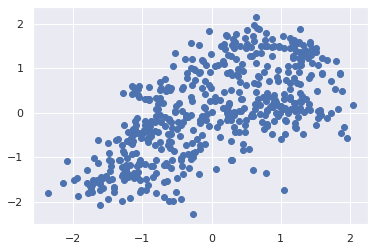

In [30]:
np.random.seed(0)
df_train, df_test = train_test_split(dataset, train_size = 0.7, test_size = 0.3, random_state = 100)

scaler= StandardScaler()

num_vars=['temp','hum','windspeed','cnt']
df_train[num_vars]= scaler.fit_transform(df_train[num_vars])

plt.scatter('temp','cnt',data=df_train)

In [31]:
y_train = df_train.pop('cnt')
X_train = df_train


Ahora creamos el modelo de regresión lineal:

In [32]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm,10)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('hum', False, 14),
 ('windspeed', False, 12),
 ('year', True, 1),
 ('Otoño', False, 6),
 ('Primavera', True, 1),
 ('Verano', False, 7),
 ('Dia libre', True, 1),
 ('Lluvia ligera', True, 1),
 ('Niebla', True, 1),
 ('Ago', False, 18),
 ('Dic', False, 9),
 ('Ene', False, 10),
 ('Feb', False, 11),
 ('Jul', True, 1),
 ('Jun', False, 17),
 ('May', False, 13),
 ('Mzo', False, 16),
 ('Nov', False, 8),
 ('Oct', False, 15),
 ('Sep', True, 1),
 ('Jue', False, 2),
 ('Lun', False, 5),
 ('Mar', True, 1),
 ('Mie', True, 1),
 ('Sab', False, 3),
 ('Vie', False, 4)]

In [33]:
col = X_train.columns[rfe.support_]
col

Index(['temp', 'year', 'Primavera', 'Dia libre', 'Lluvia ligera', 'Niebla',
       'Jul', 'Sep', 'Mar', 'Mie'],
      dtype='object')

In [34]:
X_train_rfe = X_train[col]
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train,X_train_rfe).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     224.0
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.59e-177
Time:                        01:11:40   Log-Likelihood:                -290.49
No. Observations:                 511   AIC:                             603.0
Df Residuals:                     500   BIC:                             649.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1359      0.043     -3.188      0.002      -0.220      -0.052
temp              0.3801      0.027     13.926      0.000       0.326       0.434
year              1.0620      0.039     27.513      0.000       0.986       1.138
Primavera        -0.7457      0.057    -13.187      0.000      -0.857      -0.635
Dia libre        -0.0924      0.044     -2.109      0.035      -0.178      -0.006
Lluvia ligera    -1.3321      0.120    -11.145      0.000      -1.567      -1.097
Niebla           -0.3511      0.041     -8.574      0.000      -0.431      -0.271
Jul              -0.2978      0.081     -3.678      0.000      -0.457      -0.139
Sep               0.2334      0.074      3.138      0.002       0.087       0.379
Mar              -0.1317      0.058     -2.263      0.024      -0.246      -0.017
Mie              -0.0659      0.058     -1.132      0.258      -0.180       0.049
==============================================================================
Omnibus:                       55.679   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.814
Skew:                          -0.704   Prob(JB):                     1.16e-20
Kurtosis:                       4.527   Cond. No.                         8.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Podemos ver que la variable Miércoles tiene un p-value mayor que 0,05, por lo que la eliminaremos.

In [35]:
X_train1 = X_train_rfe.drop('Mie',1)

X_train2 = sm.add_constant(X_train1)
lm1 = sm.OLS(y_train,X_train2).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     248.6
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.86e-178
Time:                        01:11:40   Log-Likelihood:                -291.14
No. Observations:                 511   AIC:                             602.3
Df Residuals:                     501   BIC:                             644.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1532      0.040     -3.848      0.000      -0.231      -0.075
temp              0.3806      0.027     13.941      0.000       0.327       0.434
year              1.0603      0.039     27.482      0.000       0.985       1.136
Primavera        -0.7435      0.057    -13.151      0.000      -0.855      -0.632
Dia libre        -0.0761      0.041     -1.838      0.067      -0.157       0.005
Lluvia ligera    -1.3210      0.119    -11.087      0.000      -1.555      -1.087
Niebla           -0.3498      0.041     -8.544      0.000      -0.430      -0.269
Jul              -0.3013      0.081     -3.722      0.000      -0.460      -0.142
Sep               0.2330      0.074      3.132      0.002       0.087       0.379
Mar              -0.1171      0.057     -2.063      0.040      -0.229      -0.006
==============================================================================
Omnibus:                       57.368   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.748
Skew:                          -0.709   Prob(JB):                     5.95e-22
Kurtosis:                       4.606   Cond. No.                         8.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lo mismo pasa con Día libre y Mar, por lo que las eliminaremos también.

In [36]:
X_train1 = X_train_rfe.drop(['Dia libre', 'Mie', 'Mar'], 1)

X_train2 = sm.add_constant(X_train1)
lm2 = sm.OLS(y_train,X_train2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     315.7
Date:                Wed, 09 Jun 2021   Prob (F-statistic):          1.54e-179
Time:                        01:11:40   Log-Likelihood:                -294.48
No. Observations:                 511   AIC:                             605.0
Df Residuals:                     503   BIC:                             638.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1967      0.036     -5.510      0.000      -0.267      -0.127
temp              0.3870      0.027     14.179      0.000       0.333       0.441
year              1.0595      0.039     27.339      0.000       0.983       1.136
Primavera        -0.7372      0.057    -12.994      0.000      -0.849      -0.626
Lluvia ligera    -1.3144      0.120    -10.987      0.000      -1.549      -1.079
Niebla           -0.3452      0.041     -8.420      0.000      -0.426      -0.265
Jul              -0.3048      0.081     -3.756      0.000      -0.464      -0.145
Sep               0.2308      0.075      3.090      0.002       0.084       0.378
==============================================================================
Omnibus:                       62.060   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.433
Skew:                          -0.756   Prob(JB):                     7.73e-24
Kurtosis:                       4.648   Cond. No.                         7.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
X_train_new = X_train2.drop('const',axis=1)

In [38]:
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,temp,2.00
2,Primavera,1.83
1,year,1.43
5,Jul,1.34
4,Niebla,1.30
6,Sep,1.14
3,Lluvia ligera,1.02


El factor de inflación de la varianza es una herramienta que ayuda a identificar el grado de multicolinealidad. Una regresión múltiple se usa cuando una persona quiere probar el efecto de múltiples variables en un resultado en particular. La variable dependiente es el resultado sobre el que actúan las variables independientes (las entradas del modelo). La multicolinealidad existe cuando existe una relación lineal, o correlación, entre una o más de las variables independientes o entradas. De ahí que se eliminaran ciertas variables al principio.

Un VIF de 1 indica que dos variables no están correlacionadas, entre 1 y 5 indica una correlación moderada y por encima de 5 indica una alta correlación. Por lo que tener todas las variables por debajo de 5 VIF es lo que queremos.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Errores')

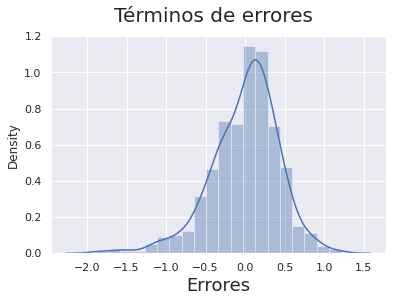

In [39]:
y_train_pred = lm2.predict(X_train2)

fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Términos de errores', fontsize = 20)
plt.xlabel('Errores', fontsize = 18) 

Ahora hacemos las predicciones.

In [40]:
num_vars=['temp','hum','windspeed','cnt']
df_test[num_vars]= scaler.transform(df_test[num_vars])

y_test = df_test.pop('cnt')
X_test = df_test

X_test_new = X_test[X_train_new.columns]
X_test_new = sm.add_constant(X_test_new)

y_test_pred = lm2.predict(X_test_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Por último, evaluamos con el modelo.

Text(0, 0.5, 'Predicciones')

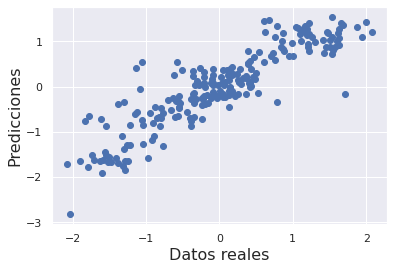

In [41]:
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
plt.xlabel('Datos reales', fontsize=16)
plt.ylabel('Predicciones', fontsize=16)

In [42]:
r2_score(y_test, y_test_pred)

0.7925566809149787

La bondad, R^2 o coeficiente de determinación, es mejor cuanto más se acerca a 1, por lo que nuestro resultado es bastante bueno.